<a href="https://colab.research.google.com/github/timlamec/work/blob/master/PalmDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Training a Single-Shot-Detector model to detect palm trees in aerial imagery
!pip install arcgis

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 194kB 43.3MB/s 
     |████████████████████████████████| 15.3MB 45.6MB/s 
     |████████████████████████████████| 61kB 22.3MB/s 
     |████████████████████████████████| 2.3MB 38.8MB/s 
     |████████████████████████████████| 112kB 50.2MB/s 
  Created wheel for arcgis: filename=arcgis-1.6.2.post1-py2.py3-none-any.whl size=1722725 sha256=2a1018df1ec7aa582357e53a74c566192f6c6a4d9269d58e2dd9485b42443457
  Stored in directory: /root/.cache/pip/wheels/f7/64/05/a36e62d3e3f043a30a1c92e43f82fde76a387e6478124c4ace
  Created wheel for pyshp: filename=pyshp-1.2.11-cp36-none-any.whl size=22463 sha256=9577f127ece8d99943f807c29a4042679fd6314c712822944c393d32a2377c2c
  Stored in directory: /root/.cache/pip/wheels/e0/25/e1/c02348b30bde207b78388f29df97bdabb0567056fdd3e209d8
Successfully built arcgis pyshp
ERROR: jupyterlab-server 1.0.6 has requirement jsonschema>=3.0.1, but you'll have jsonschema 2.6.0 which is

In [ ]:
# Import necessary ArcGIS Python API tools:

from arcgis.learn import SingleShotDetector, prepare_data

Since this is a deep learning model, you need to create two classes of data to train the model. The  `prepare_data` function you imported reads the data from the directory and format you placed it in using the Export Training Data for Deep Learning tool in ArcGIS Pro. This can also be done programmatically using the `export_training_data` function in the `arcgis.learn` module. This function returns a `fast.ai` `DataBunch` object, which can be used by the `SingleShotDetector` class.

The SingleShotDetector function accepts several required arguments. First, the data path, is a string containing the path to directory where the chips and labels were extracted. The directory structure is written as follows:

`data/
----images/
----lables/`

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# This variable holds the path to the training examples you exported from ArcGIS Pro.

# TO DO: Update the path to your CoconutHealth project where you saved the ImageChips folder.

data_path = r'/content/drive/My Drive/Colab Notebooks/deeplearning/DeepLearning/Data'

The second required argument is a `class_mapping` dictionary, which maps the integer labels in the xml file to a string. This argument is for visualization purposes, so you can see the data that's been added to the specified classes. You'll set this dictionary as {1:'Palm'} to tell the classes that the value 1 denotes palm trees (which you set in the ClassValue parameter. Where the model detects pixels with a value of 1, it will label palm trees.

The final important parameter is `chip_size`, which specifies the size of the image that will be passed to the model. The default settings of this parameter specify that a random 224 px sized crop is taken from the original image. You exported a 448x448 px image, so leaving this argument blank will randomly crop out 224x224 px chips from it as additional augmentation during training.

In [ ]:
!pip install torch torchvision

In [ ]:
# Run the function with the correct arguments for the data path and class mapping. 
#The second parameter allows for specifying text labels for the classes.

data = prepare_data(data_path, {1:'Palm'}) 

Exception: ignored

The `prepare_data` function used approximately 10 percent of the image chips to train the model to recognize palm trees. The other 90 percent is used to test the model's accuracy.

In [ ]:
# Checking on the classes loaded with the data:
data.classes

['background', 'Palm']

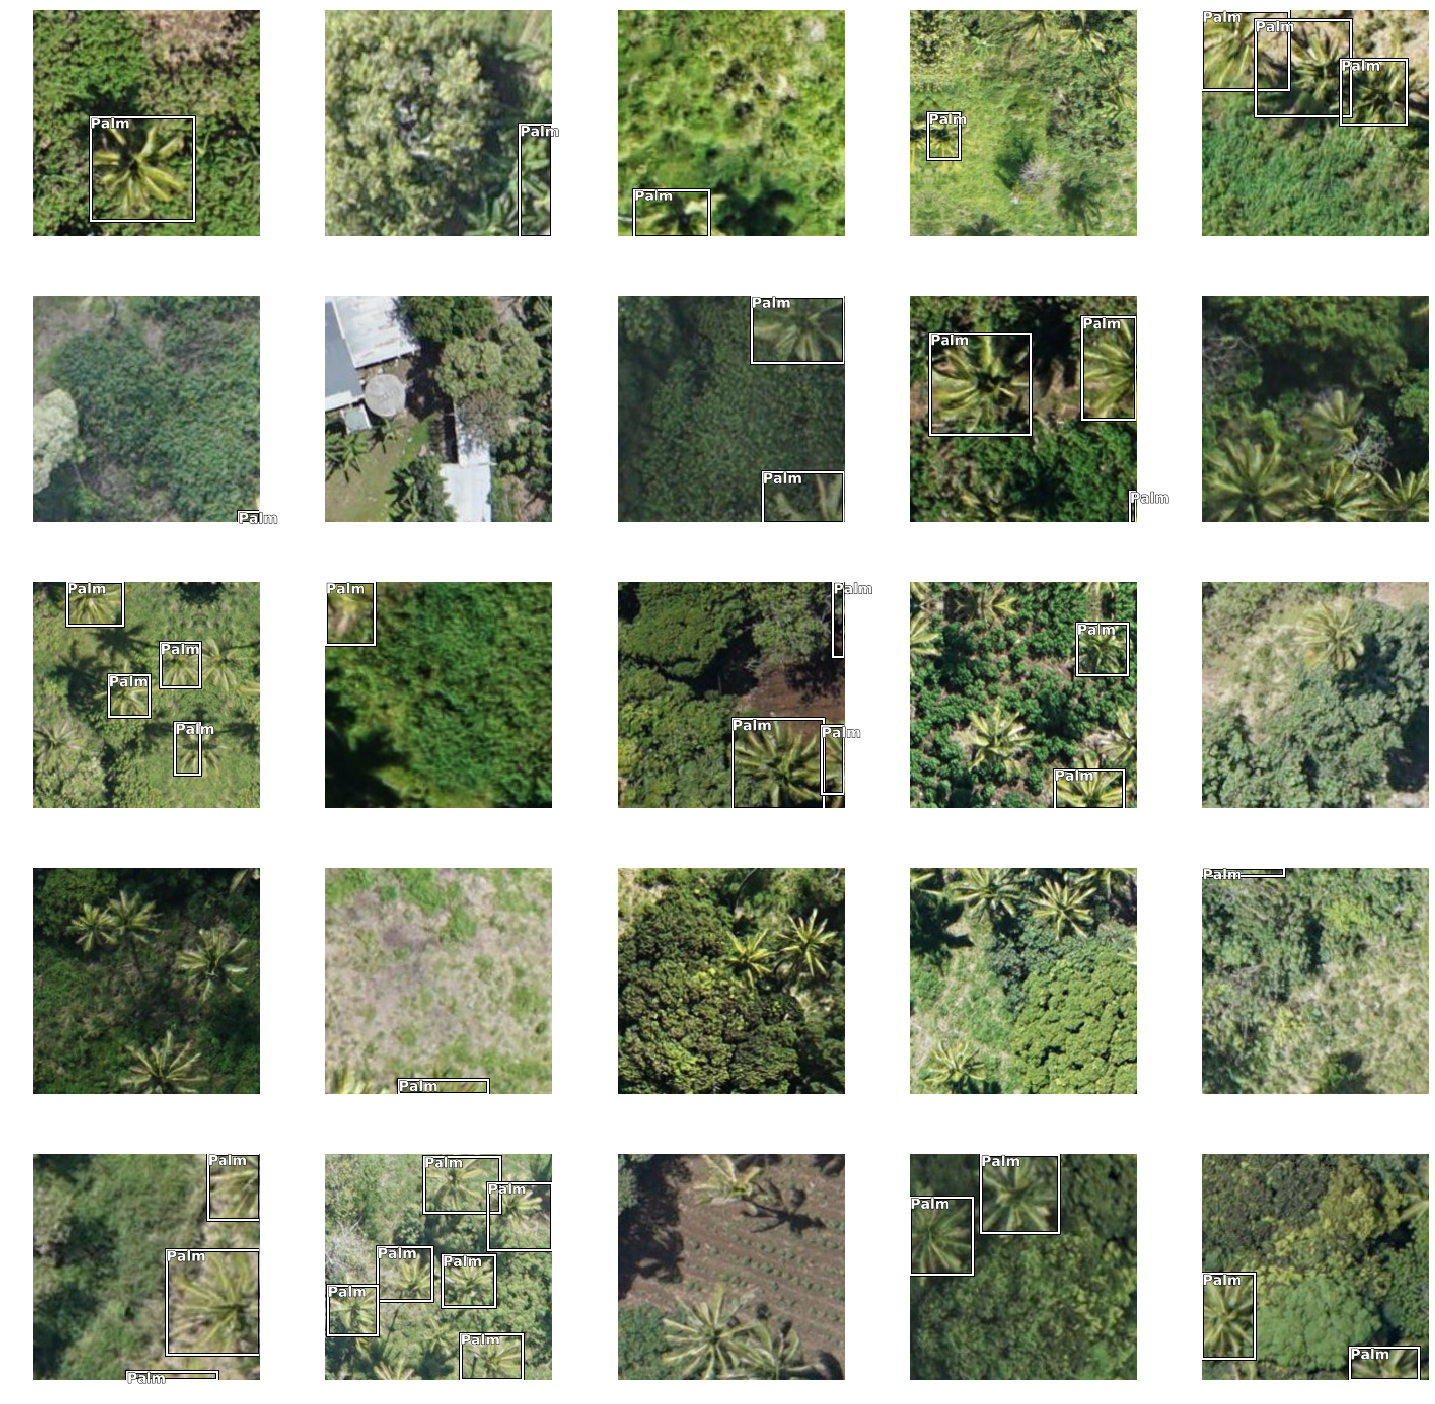

In [ ]:
# Visualize a random batch from the training set to make sure the data is loaded correctly and ready for training:
data.show_batch()

#### Simple SSD: Constructor

Simplistically, the single shot detector method detects objects in images by scoring an initial set of objects digitized in bounding boxes. Through the course of iterations, or epochs, the model redraws the bounding boxes as it becomes better able to detect the shape of the desired object. The `SingleShotDetector` (SSD) class contains functions that iteratively build the model's architecture. For each class definition, there is a seperate architecture that is built internally. The output object of this class can be used to train the model, see the results and save the model and its Esri model definition(emd) file.

There are three main parameters that define a `SingleShotDetector`: Grids, Zooms and Ratios. 

**Grids :** This defines in how many grids the image will be divided into. Supposing the parameter is set to `[4]`, it will divide the image in 4x4 grids. The 4x4 grid has 16 grid cells responsible for prediction of bounding boxes. Similiarly, if the grid is set to `[2]`, the image will be divided into a 2x2 grid and then 4 grid cells will be responsible for detecting objects. If you pass a list (i.e `[4,2,1]`), the image will be divided into each of those grids and a total of 21(16 + 4 + 1) grid cells will be scanned for objects.

**Zooms :** This defines how many zoom levels each grid cell will be scaled up or down to depending on the number that you pass. If you pass `[1]`, all the grid cells will remain of same size. If you pass `[2]`, all the grid cells will become twice as large. If you pass a list, all the grid cells will be scaled using all the numbers in the list. All 21 of the grid cells of your `[4,2,1]` grid will be scaled by `[0.7,1.0,1.3]`, and these numbers make a total of 63 (21 * 3) anchor boxes. The scaled versions of grid cells are called anchor boxes, which are responsible for detecting objects.

**Ratios :** These ratios define the aspect ratio of the anchor box. So it's a list of lists; if you pass a list of `[[1,1]]`, the anchor box is a square. If it's a list like `[[1, 0.5]]` then the anchor box will become a vertical rectangle with it width halved and height doubled. In a default scenario i.e `[[1.0, 1.0], [1.0, 0.5], [0.5, 1.0]]`, the earlier 63 anchor boxes will be made this way and a total of 189 (63 * 3) anchor boxes will be created and will be responsible for detecting objects.

The **backbone** parameter is a pretrained model imported from `torchvision` to be used as a backbone for the `SingleShotDetector` head. The SSD head is the number of convolutional layers added to the tail to produce output bounding boxes. You won't experiment with this parameter during this exercise: the backbone in this case is "frozen".

In [ ]:
# Instantiating Single Shot Detector model:
ssd = SingleShotDetector(data, grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]])

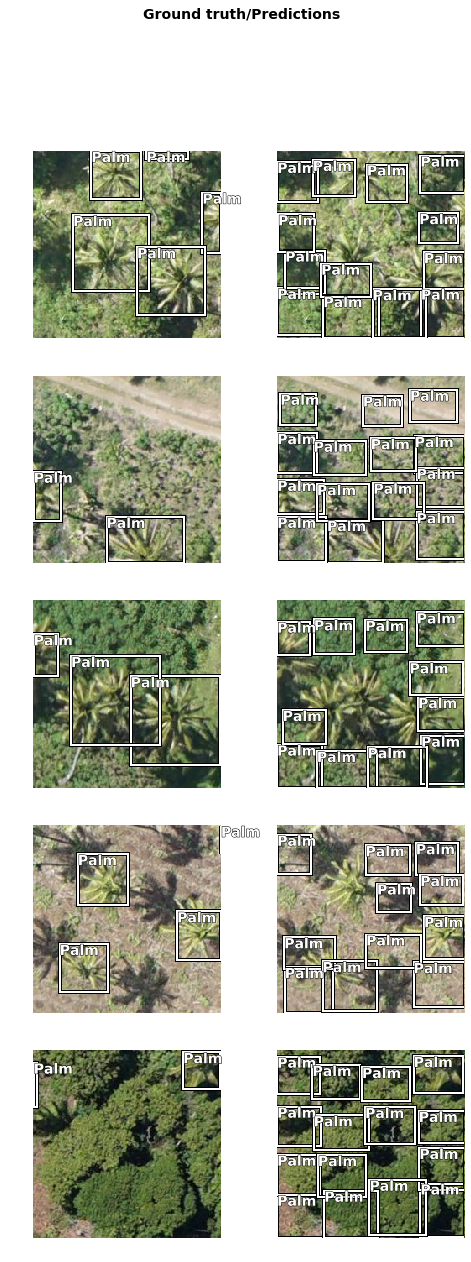

In [ ]:
# What does the SSD model output before it's been trained?
# Note the random-looking detection boxes in the right column.
ssd.show_results(thresh=0.2)

#### Simple SSD: Training

To tune the most important hyperparameter in deep learning models, the learning rate, you'll call one of the SSD's object functions called the `lr_finder`. By inspecting the resulting graph, you can select a good learning rate value. An optimal learning rate is a maximum value where the slope of the graph is still decreasing. 

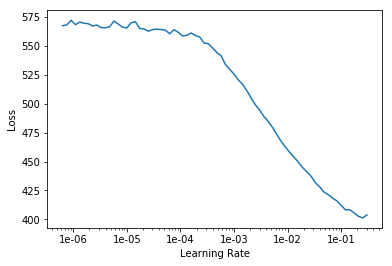

In [ ]:
# Use the Learning Rate Finder utility to determine the optimal learning rates for the Backbone and the Head of SSD:

ssd.lr_find()

Before you perform the actual training of the model, you'll inspect the training and validation loss graphs.

If the validation loss graph starts consistently going up, you may have overtrained (overfitted) the model. If the validation loss keeps going down or stays stable, there may still be a room for improvement.

Training the Head only: Transfer Learning:
To speed up the process of training, you'll use only a subportion of the SSD network, which is directly responsible for the detection and classification of your target object classes. The "Backbone" portion of the SSD remains "frozen" with weights pretrained on an ImageNet dataset. 
If you had more time and samples to train on, it would be worthwhile to experiment and see if training of the backbone may also improve the detection results. To train the backbone, you would call `ssd.unfreeze()` before beginning the training.

To start, you'll train the model for the specified number of epochs (20). For the Backbone (first lr parameter, not used since backbone is frozen) you'll accept the default value of 1e-5, but for the Head (second lr parameter), you'll use the graph above to specify a good parameter.

Hint: you can keep training ssd through multiple iterations, calling `ssd.fit(50,...)`, then `ssd.fit(100,....)` again, etc.
For this task, the total number of epochs to train ssd to an accepatable quality should not be much greater than 300.
If you want to start training from scratch, just call the `SingleShotDetector` constructor again. You can also re-start training from a particular checkpoint - see comments below on `ssd.save()`.

In [ ]:
#TODO: looking at the lr_find() chart above, replace the ??? with a good learning rate for the SSD's Head
#Remember, a good learning rate tends to be the lowest point on the validation loss graph before the line starts trending upward.

ssd.fit(20, lr=slice(1e-5, ???)) 

In [ ]:
# Once the initial training is complete, examine how the loss function on Training and Validation sets looks - 
# are there signs of overfitting? or can we keep training?

ssd.learn.recorder.plot_losses()

In [ ]:
# What is the average precision score for the detections at this point?
# Does it keep going up after additional epochs of training?

ssd.average_precision_score() 

{'Palm': 0.6635719769685513}

In [ ]:
#A file named **models** was created in your ArcGIS Pro project folder. Save the model to the models folder. 

ssd.save('YOUR-MODEL-NAME') # Name your model. You may want to add number of epochs trained to the name, e.g. "myModel_e150"

WindowsPath('C:/Users/yong9856/Downloads/ImageChips24/models/stage-20')

Once the model is trained to a certain accuracy, it can be saved locally - a "checkpoint".
A saved model can be used in ArcGIS Pro for local inferencing, or uploaded to Portal for ArcGIS to become an inferencing service.

The more times you iterate through the training process, checking for overfitting, the better a model tends to be. Opttionally, run the code below and continue to improve your model before bringing it back to ArcGIS Pro for object detection.

Note: You may also want to save intermediate checkpoints between iterations of training, so you can return back to one in case the next portion of training epochs takes the model in a wrong direction, e.g. network starts overfitting the training set.
To load ssd from a checkpoint: ssd = SingleShotDetector.from_emd(data, r'<path_to_emd_file>')

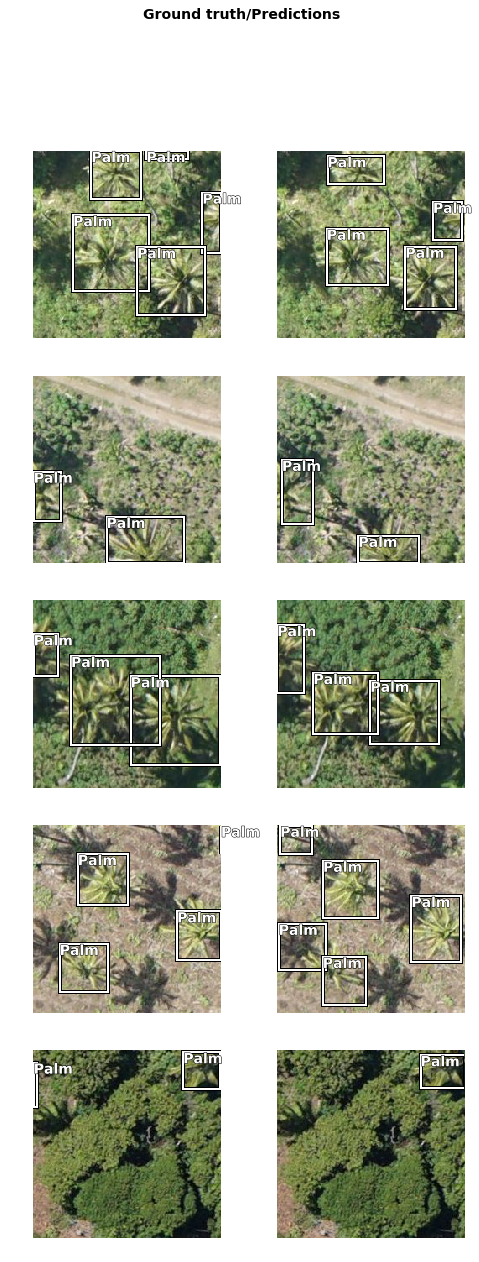

In [ ]:
# OPTIONAL:How does the output of the model which was trained for NNN epochs change?

ssd.show_results(thresh=0.4)

# Will the accuracy improve, if you train for additional epochs? 
# Go back to the cell containging ssd.fit(...) above, and run it again for additional epochs of training.
# Once trained for additional epochs, run the loss function chart cell:
#   - is loss function still going down?
#   - any signs of overfitting?
# Don't forget to save a checkpoint.

Now, you'll use the model you created as input for the Detect Objects Using Deep Learning tool in ArcGIS Pro.